<a href="https://colab.research.google.com/github/Gulnar9/pytorch-deep-learning/blob/main/01_pytorch_workflow_gulnar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu121'

## Data preparing and loading



In [ ]:
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Train test split

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):

  '''
  Plots training data, test data and compares preds
  '''

  # Plot training data in blue
  plt.scatter(train_data,train_labels, c='b', s=4,label='Training data')

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  # Are there predictions
  if predictions is not None:
    # Plot preds if exists
    plt.scatter(test_data,predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(prop={'size':14});

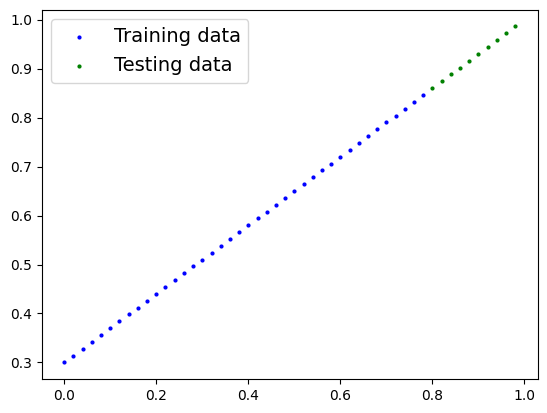

In [ ]:
plot_predictions();

## Build model

In [ ]:
# Create Lin Regr model class
# almost everything in PyTorch inherits from nn.Module
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.rand(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.rand(1,
                                         requires_grad=True,
                                         dtype=torch.float))

    # Forward method to define the computation in the model
  def forward(self,x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weights * x + self.bias

### PyTorch model building essentials

* torch.nn
* torch.nn.Parameter
*torch.nn.Module - base class for nn modules, if you subclass it you should overwrite forward()
* torch.optim
* def forward()

In [ ]:
# Checking the content of model
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

list(model_0.parameters())


[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

### Making prediction using torch.inference_mode()

When we pass data through our model, it is going to run it through forward() method

inference_mode() - disables grad tracking, faster computation

similar to torch.no_grad(), however torch.inference_mode() preferred

In [ ]:
# Make preds with model

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

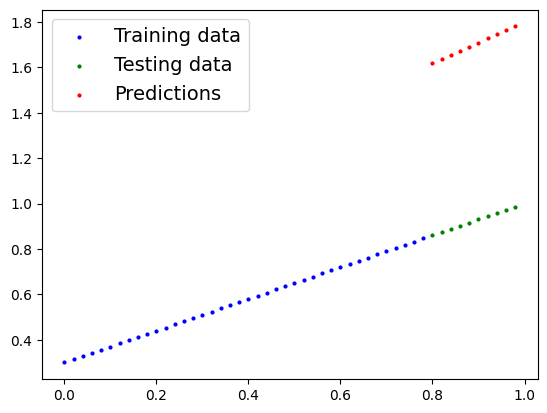

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from unknown params(these may be random) to some known params.

One way to measure how poor the model`s predictions are is to use loss function.

* Note: Loss function may also be called as cost function or criterion in different areas.
* **Loss function**: A function to measure how wrong model`s preds are to the ideal outputs, lower is better
* **Optimizer**: Takes into account the loss of a model and adjusts the model`s params(weight, bias in our case) to improve the loss function.
  - Inside the optimizer you`ll often have to set two parameters:
     - params - the model parameters you`d like to optimize, for ex. params=model_0.parameters()
     - lr(learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step..

For PyTorch we need:
* A training loop
* A testing loop


In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our models` 'forward()' functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass preds to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model`s parameters to try and improve the loss (**gradient descent**)


In [ ]:
# An epoch is one loop through the data...
epochs = 100

# Track diff values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train()  # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  #print(f'Loss: {loss}')

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the params of the model
  loss.backward()

  # 5. Step the optimizer (performs gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()  # turns off diff settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode():  # turns off gradient tracking
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what`s happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss:{test_loss}')
    # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.6860889196395874 | Test loss:0.7637526988983154
OrderedDict([('weights', tensor([0.8784])), ('bias', tensor([0.9050]))])
Epoch: 10 | Loss: 0.5708791017532349 | Test loss:0.6290428042411804
OrderedDict([('weights', tensor([0.8394])), ('bias', tensor([0.8050]))])
Epoch: 20 | Loss: 0.45566922426223755 | Test loss:0.4943329691886902
OrderedDict([('weights', tensor([0.8004])), ('bias', tensor([0.7050]))])
Epoch: 30 | Loss: 0.34045934677124023 | Test loss:0.35962313413619995
OrderedDict([('weights', tensor([0.7614])), ('bias', tensor([0.6050]))])
Epoch: 40 | Loss: 0.2252494841814041 | Test loss:0.2249133139848709
OrderedDict([('weights', tensor([0.7224])), ('bias', tensor([0.5050]))])
Epoch: 50 | Loss: 0.1100396141409874 | Test loss:0.09020347893238068
OrderedDict([('weights', tensor([0.6834])), ('bias', tensor([0.4050]))])
Epoch: 60 | Loss: 0.009724985808134079 | Test loss:0.020998019725084305
OrderedDict([('weights', tensor([0.6539])), ('bias', tensor([0.3200]))])
Epoch:

In [ ]:
import numpy as np
np.array(torch.tensor(loss_values).numpy())
#np.array(torch.tensor(test_loss_values).numpy())

array([0.6860889 , 0.5708791 , 0.45566922, 0.34045935, 0.22524948,
       0.11003961, 0.00972499, 0.00621675, 0.00278832, 0.00709595],
      dtype=float32)

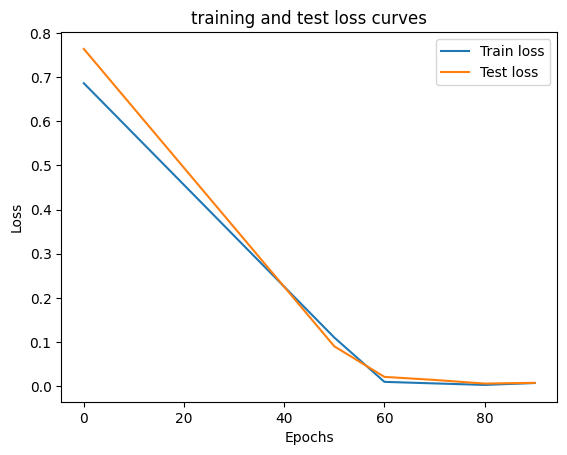

In [ ]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = 'Train loss')
plt.plot(epoch_count, test_loss_values, label = 'Test loss')
plt.title('training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

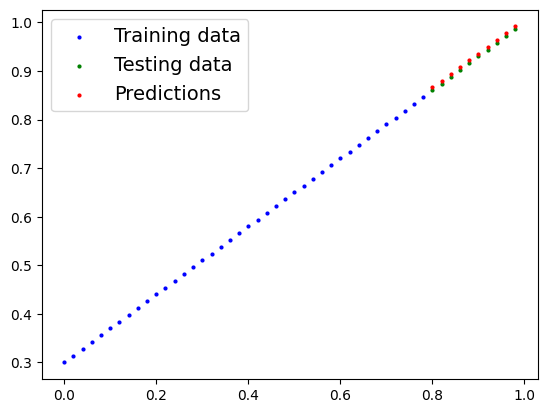

In [ ]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

There are 3 main methods for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python`s pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. torch.nn.Module.load_state_dict() - this allows to load a model`s saved state dictionary

In [ ]:
# Saving a model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create models save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Feb  4 19:32 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model`s state_dict() rather the entire model, we`ll create a new instance of our model class and load the saved state_dict() into that

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [ ]:
loaded_models_0 = LinearRegressionModel()

# Load the saved state dict of model_0 (this will update the new instance with updated parameters)
loaded_models_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_models_0.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [ ]:
# Make some predictions
loaded_models_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_models_0(X_test)

loaded_model_preds


tensor([[0.8661],
        [0.8801],
        [0.8940],
        [0.9080],
        [0.9220],
        [0.9359],
        [0.9499],
        [0.9638],
        [0.9778],
        [0.9917]])

In [ ]:
# Make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

In [ ]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu121'

### 6.1 Data
 Create device-agnostic code (if GPU available it will use GPU, else CPU)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu
